# Submission by Shivani Tayade and Sravya Bhaskara (Section 2)

# #4 Probability Review 

In [192]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import probplot

In [2]:
# probability shared
prevalence = 0.02  # Probability of having the disease (P(D))
sensitivity = 0.98  # P(Positive | D)
specificity = 0.95  # P(Negetive |  not D) 

## Calculation using Bayes' Theorem

In [5]:
# P(D | Positive) = (P(Positive | D) * P(D)) / P(Positive)
# We have all the details in above equation except P(Positive) and we can calculate the P(Positive) as below
# P(Positive) = P(Positive | D) * P(D) + P(Positive | not D) * P( not D)

# Probability of a positive test result given no disease (P(Pos | not D))
p_positive_given_no_disease = 1 - specificity

# P(Positive)
p_positive = sensitivity * prevalence + p_positive_given_no_disease * (1 - prevalence)


print("the probability that the test returns positive result is")
print(p_positive)

# P(D | Positive) - our final answer
p_d_given_pos = (sensitivity * prevalence) / p_positive

print("the probability that a person has the disease given that they tested positive is")
print(p_d_given_pos)

the probability that the test returns positive result is
0.06860000000000005
the probability that a person has the disease given that they tested positive is
0.2857142857142855


## Simulation

In [17]:
# Simulate a large population - using 1 million

prevalence = 0.02
population_size = 1000000
disease = np.random.choice([1, 0], size=population_size, p=[prevalence, 1 - prevalence])  # 1: has disease, 0: no disease

# Generating the overall test results  on sensitivity and specificity
test_results = np.zeros(population_size)


test_results[disease == 1] = np.random.choice(
    [1, 0], size=np.sum(disease == 1), p=[sensitivity, 1 - sensitivity]
)
test_results[disease == 0] = np.random.choice(
    [1, 0], size=np.sum(disease == 0), p=[1 - specificity, specificity]
)

tested_positive = test_results == 1
actual_disease_among_positive = np.sum(disease[tested_positive] == 1)
tested_positive_total = float(np.sum(tested_positive))
simulated_p_d_given_pos = actual_disease_among_positive / tested_positive_total

#print(tested_positive)

print(actual_disease_among_positive)

print(tested_positive_total)

print(simulated_p_d_given_pos*100)

19745
68995.0
28.618015798246248


## Comparing the results with bayes vs simluation with the changing prevalence

In [20]:
def calculate_posterior(prevalence, sensitivity, specificity):
    p_positive_given_no_disease = 1 - specificity
    p_positive = sensitivity * prevalence + p_positive_given_no_disease * (1 - prevalence)
    return (sensitivity * prevalence) / p_positive

prevalences = [0.01, 0.05, 0.1, 0.2]

#Calculating using the bayes theorem
for p in prevalences:
    posterior = calculate_posterior(p, sensitivity, specificity)
    print("P(D | Pos) with prevalence using Bayes theorem", p)
    print(round(posterior,2))

# Simulation using the modified prevalence
for p in prevalences:
    disease = np.random.choice([1, 0], size=population_size, p=[p, 1 - p])
    test_results[disease == 1] = np.random.choice([1, 0], size=np.sum(disease == 1), p=[sensitivity, 1 - sensitivity])
    test_results[disease == 0] = np.random.choice([1, 0], size=np.sum(disease == 0), p=[1 - specificity, specificity])

    tested_positive = test_results == 1
    actual_disease_among_positive = np.sum(disease[tested_positive] == 1)
    tested_positive_total = float(np.sum(tested_positive))
    simulated_p_d_given_pos = actual_disease_among_positive / tested_positive_total
    print("Simulated P(D | Pos) with prevalence", p )
    print(round(simulated_p_d_given_pos,2))


P(D | Pos) with prevalence using Bayes theorem 0.01
0.17
P(D | Pos) with prevalence using Bayes theorem 0.05
0.51
P(D | Pos) with prevalence using Bayes theorem 0.1
0.69
P(D | Pos) with prevalence using Bayes theorem 0.2
0.83
Simulated P(D | Pos) with prevalence 0.01
0.17
Simulated P(D | Pos) with prevalence 0.05
0.51
Simulated P(D | Pos) with prevalence 0.1
0.69
Simulated P(D | Pos) with prevalence 0.2
0.83


In [22]:
# From the above results we can say that both Bayes Theorem and simulation result in same probability
# However there is a minute difference in probabilities in both of the approaches

# As we changed the prevalence from 0.01 to 0.2, the posterior probabilities increased
# From above result, changing prevalence from 0.01 to 0.05, the probabilities changed from 0.1 to 0.5 in both methods

# #5 Multiple Linear Regression - California Housing Prices

## Load the Data

In [26]:
# Load the dataset manually
df = pd.read_csv("housing.csv")
df.head(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY


## Data Exploration

In [29]:
# Brief description of the dataset
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [31]:
# Number of observations, features, and their types
rows, columns = df.shape
print("Number of Observations: ", rows, "\n")
print("Number of Features: ", columns, "- Including Target Variable\n")
print("Data Types present in DataFrame\n")
print(df.dtypes)

Number of Observations:  20640 

Number of Features:  10 - Including Target Variable

Data Types present in DataFrame

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object


In [33]:
print("Out of 10 Variables, all of them are numeric, except for one (ocean_proximity) ")

Out of 10 Variables, all of them are numeric, except for one (ocean_proximity) 


In [35]:
df['ocean_proximity'].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

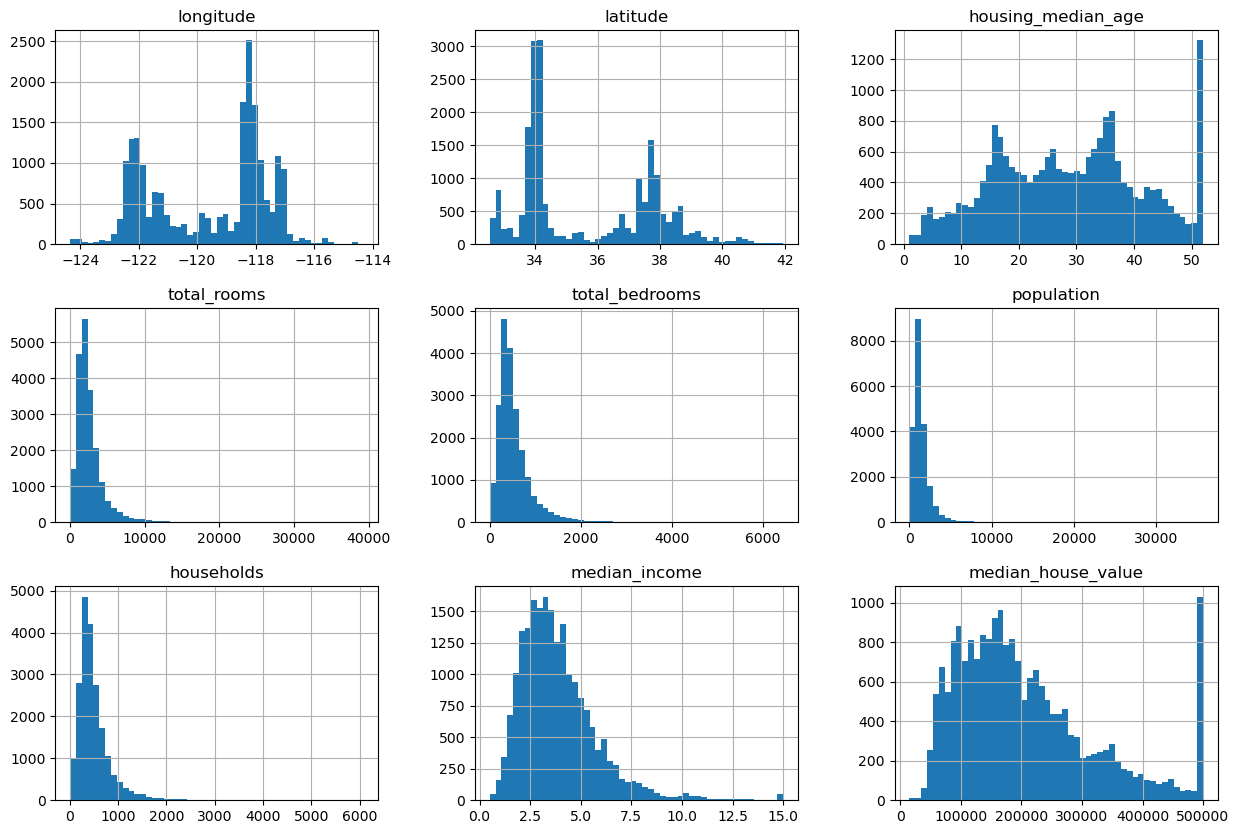

In [37]:
# EDA to understand the distribution of each feature and identify any missing values or outliers

df.hist(bins=50, figsize=(15,10))
plt.show()

In [38]:
# Check for missing values
print(df.isnull().sum())

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


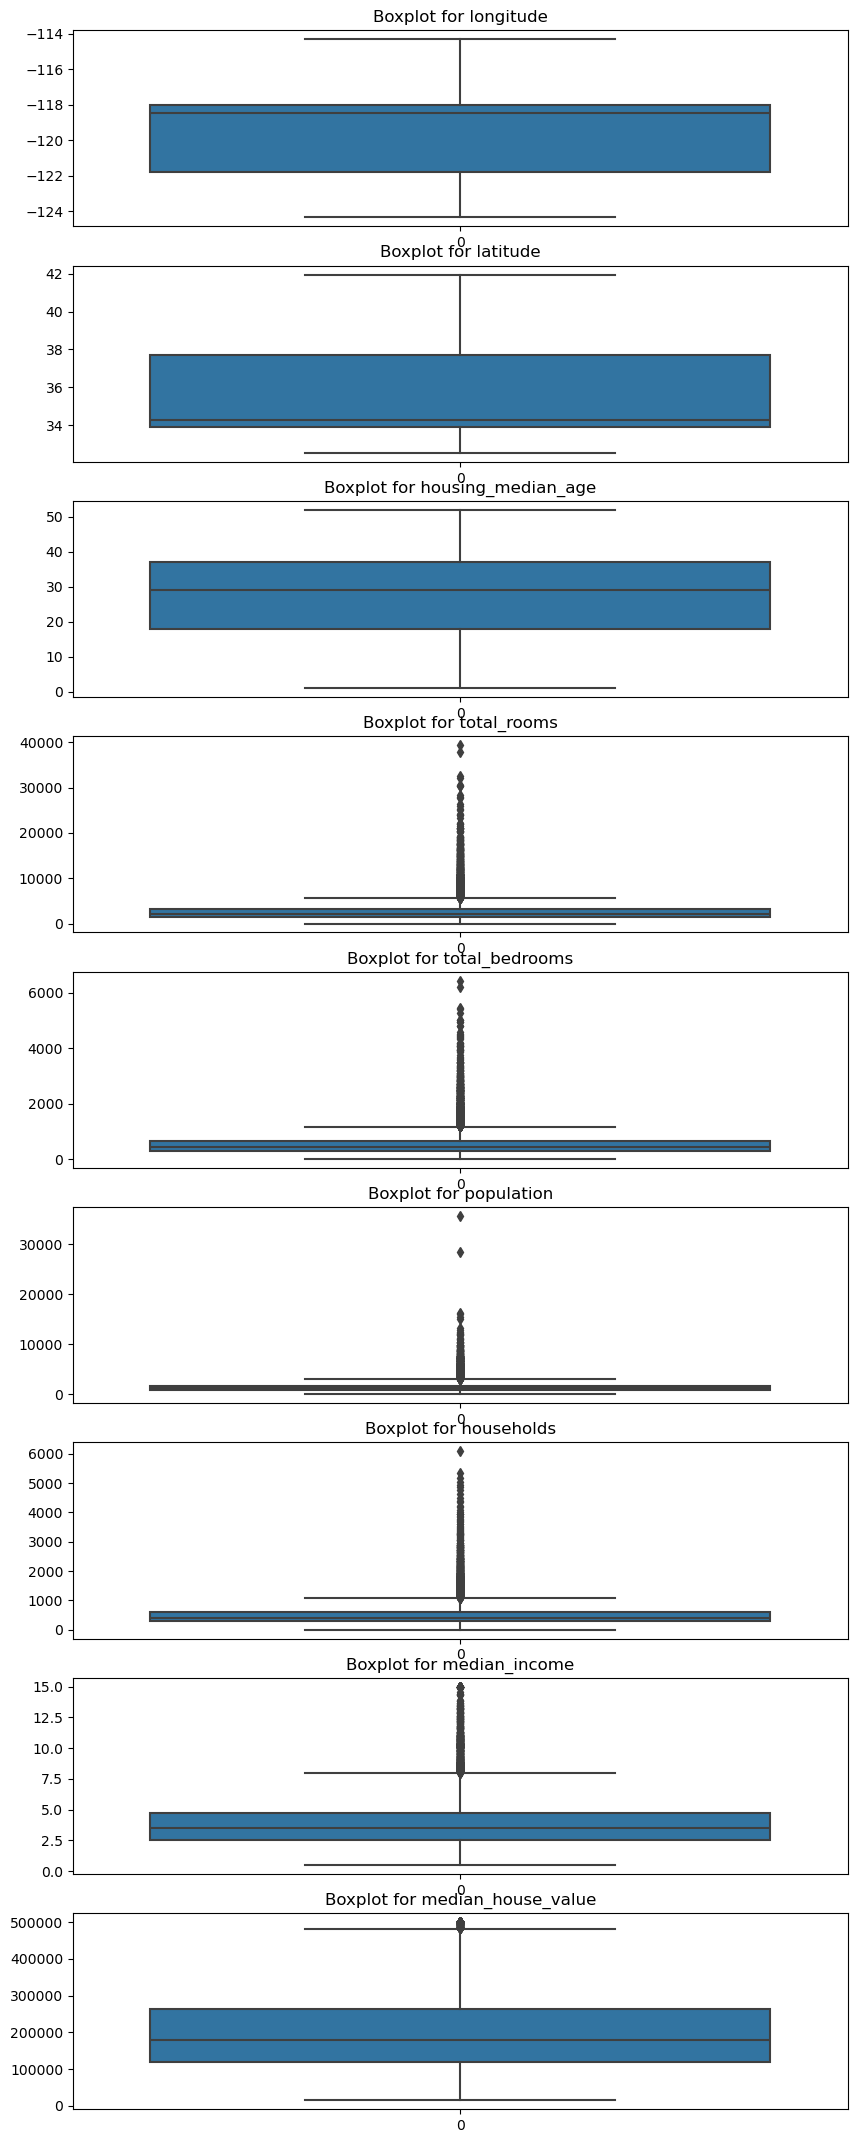

In [41]:
# Create boxplots for each feature in the dataset

df_temp = df.drop('ocean_proximity', axis=1)

plt.figure(figsize=(10, len(df_temp.columns) * 3))

# Create a boxplot for each feature
for i, feature in enumerate(df_temp.columns):
    plt.subplot(len(df_temp.columns), 1, i + 1)  
    sns.boxplot(data=df_temp[feature])  
    plt.title(f'Boxplot for {feature}')

plt.show()

In [43]:
# From Histograms, we understand distribution of each feature as follows
# Longitude: The distribution shows that data points are clustered in a specific geographic locations 
# Latitude: Similar to longitude, the data points are concentrated around specific locations
# Housing Median Age: The distribution is left skewed, which says most of the houses are old
# Total Rooms: The distribution is right skewed, with most properties having fewer total rooms
# Total Bedrooms: The distribution is Right skewed, similar to total rooms
# Population: The distribution is right skew, suggesting most of the areas have less population
# Households: Similar to population and total rooms, The distribution is right skewed
# Median Income: Distribution shows most incomes concentrated in the middle range (2 to 6), suggesting middle-income groups.
# Median House Value: The distribution is capped at the maximum value (500,000)

In [45]:
# There are no missing values in any of the features, except in total_bedroom (207 Missing values)

In [47]:
# From Box plots, we understand following
# Longitude, Latitude, Housing Median Age do not have outliers
# Total Rooms, Total Bedrooms, Population, Households have outliers to the right

## Data Processing 

In [50]:
# In Data Processing, we do following steps
# Missing Data: We have missing data in total_bedrooms. We impute the values using median
# Normalizing for numerical data
# One hot encoding for categorical data

In [52]:
# Handle missing data. Justify method of imputing or removing missing value

print("Column: total_bedrooms has outliers, which is a numerical column")
print("Median is the right statistical value to impute as it is not sensitive to outliers. \n")
median_value = df['total_bedrooms'].median()
df['total_bedrooms'].fillna(median_value, inplace=True)

print(df.isnull().sum())

Column: total_bedrooms has outliers, which is a numerical column
Median is the right statistical value to impute as it is not sensitive to outliers. 

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64


In [54]:
# Normalize or standardize the features if necessary. Explain your choice.

print("We will go ahead with standardizing. Since the data has columns with different scales and also outliers \n")
print("Standardizing helps in address these issues. \n")
print("For Categorical column, we do one hot encoding \n")

# Step 1: Standardize numeric columns
scaler = StandardScaler()
features_to_standardize = df.drop('ocean_proximity', axis=1)
df_standardized = scaler.fit_transform(features_to_standardize)
df_standardized = pd.DataFrame(df_standardized, columns=features_to_standardize.columns)

# Step 2: One-Hot Encode 'ocean_proximity' column
encoder = OneHotEncoder(drop='first', sparse_output=False)
ocean_proximity_encoded = encoder.fit_transform(df[['ocean_proximity']])
ocean_proximity_encoded_df = pd.DataFrame(ocean_proximity_encoded, columns=encoder.get_feature_names_out(['ocean_proximity']))

# Step 3: Combine both DataFrames
df_final = pd.concat([df_standardized, ocean_proximity_encoded_df], axis=1)

print(df_final.head())


We will go ahead with standardizing. Since the data has columns with different scales and also outliers 

Standardizing helps in address these issues. 

For Categorical column, we do one hot encoding 

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0  -1.327835  1.052548            0.982143    -0.804819       -0.972476   
1  -1.322844  1.043185           -0.607019     2.045890        1.357143   
2  -1.332827  1.038503            1.856182    -0.535746       -0.827024   
3  -1.337818  1.038503            1.856182    -0.624215       -0.719723   
4  -1.337818  1.038503            1.856182    -0.462404       -0.612423   

   population  households  median_income  median_house_value  \
0   -0.974429   -0.977033       2.344766            2.129631   
1    0.861439    1.669961       2.332238            1.314156   
2   -0.820777   -0.843637       1.782699            1.258693   
3   -0.766028   -0.733781       0.932968            1.165100   
4   -0.759847   -0.629157  

## Model Building

In [57]:
# Construct a multiple linear regression model using MEDV (median
# house value in $1000s) as the dependent variable and the other features as independent variables.
# Split the data set into training and test sets (e.g., 70-30 split) and justify your choice of splitting ratio

X = df_final.drop('median_house_value', axis=1)  # Features
y = df_final['median_house_value']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("We choose 70-30 split as it is used most commonly for regression \n")
print("70% for training data is enough to find underlying in data.")


We choose 70-30 split as it is used most commonly for regression 

70% for training data is enough to find underlying in data.


In [59]:

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [61]:
print("Model Intercept:", model.intercept_)
print("Model Coefficients:", model.coef_)

y_pred = model.predict(X_train)

mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Model Intercept: 0.11360790688485506
Model Coefficients: [-0.46013883 -0.46118261  0.12062252 -0.11101941  0.3842319  -0.36631703
  0.1401925   0.64651846 -0.3559672   1.17761699 -0.05256867  0.02749749]
Mean Squared Error: 0.3551111393738063
R-squared: 0.6470480227253683


## Model Evaluation

In [64]:
# Fit the model on the training data and evaluate its performance on both the training and test datasets using metrics such as Mean
# Squared Error (MSE) and R-squared

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Training Set MSE: ", round(train_mse, 5), "R_square: ", round(train_r2, 5))
print("Testing Set MSE: ", round(test_mse, 5), "R_square: ", round(test_r2, 5))

Training Set MSE:  0.35511 R_square:  0.64705
Testing Set MSE:  0.35549 R_square:  0.63936


In [66]:
# Interpreting this results

# The model is performing reasonably well. The R_sqaure is 64% which says that variance of 64% is explained in both the training 
# and test datasets. Training dataset has slightly larger MSE compared to test

In [68]:
# Analyze the statistical significance of each coefficient 
# and discuss which features seem to be the most important predictors of housing prices.

X_with_constant = sm.add_constant(X)
model = sm.OLS(y, X_with_constant)
results_ols = model.fit()

print(results_ols.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     3129.
Date:                Sat, 18 Jan 2025   Prob (F-statistic):               0.00
Time:                        01:38:27   Log-Likelihood:                -18586.
No. Observations:               20640   AIC:                         3.720e+04
Df Residuals:                   20627   BIC:                         3.730e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [70]:
# Statistical significance of each coefficient:
# We use p-value to asses if the feature is statistically significant or not
# A feature is considered statistically significant if its p-value is less than 0.05
# A P-value is probability value, assuming that null hypothesis (Coeff is 0) is true

# Intercept (const): Represents value of median_house_value when all predictors are at their reference category (<1H OCEAN). Statistically significant
# longitude: Statistically significant
# latitude: Statistically significant
# housing_median_age: Statistically significant with positive coefficient
# total_rooms: Statistically significant. Negative coefficient suggests that as room number increases, price decreases
# total_bedrooms: Statistically significant. More bedrooms are positively associated with housing prices
# population: Statistically significant
# households: Statistically significant
# median_income: Higher median income is positively related to housing prices, Statistically significant.
# ocean_proximity_INLAND: Statistically significant and cheaper than reference category
# ocean_proximity_ISLAND: Statistically significant and expensive than reference category
# ocean_proximity_NEAR BAY: Only borderline significant (p-value slightly above 0.05)
# ocean_proximity_NEAR OCEAN: Statistically significant

# Based on p-values, all variables seem to be important except for ocean_proximity_NEAR BAY

# Feature Impact
# Most Positive Impact: The below features impact prices in positive way
# median_income (0.6381): 
# ocean_proximity_ISLAND (1.3525):
# Most Negative Impact:  The below features impact prices in negative way
# population (-0.3856)
# longitude (-0.4589) and latitude (-0.4660)
# ocean_proximity_INLAND (-0.3446)

# Based on feature coefficient, median_income is the most important feature

## Assumption Checking

In [73]:
# Check the assumptions of linear regression, including linearity, independence, homoscedasticity, and normality of residuals

In [75]:
# Residuals are the difference between observed and predicted values.
# In linear regression, we have few properties or assumptions for residuals

In [77]:
residuals = y_test - y_test_pred

In [79]:
# 1. Check Linearity

In [81]:
# Linearity Assumption requires the residuals to have a non symmetric pattern when they are
# plotted against predict values or observed values. i.e. Residuals should be randomly distributed
# This is needed for the model to capture linear relationship between independent and dependent variables

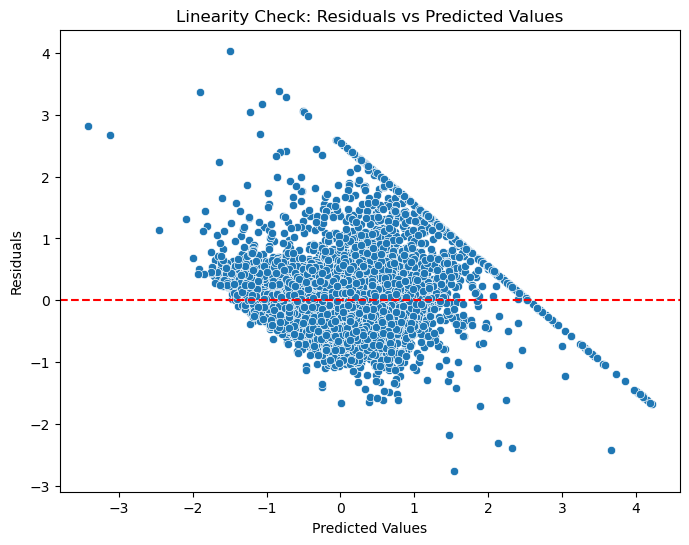

In [83]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Linearity Check: Residuals vs Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

In [84]:
# For Linearity, The residuals should be randomly scattered around horizontal (red) line
# Here, the residuals dont seem to be randomly distributed in the plot. 
# We can see some non-random pattern which violates the linearity assumption


In [87]:
# 2. Check Independence

In [89]:
# Independence meaning residuals should not be correlated with each other (No auto correlation)

In [91]:
# Check Independence (Durbin-Watson Test)
from statsmodels.stats.stattools import durbin_watson
dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson Statistic: {dw_stat:.2f}")

Durbin-Watson Statistic: 2.00


In [105]:
# If DW test statistic is close to 2 then there is no auto correlation. If its close to 0 or 4, residuals are auto correlated
# Since we got DW test statistic as 2, Independence assumption is satisfied

In [107]:
# 3. Check Homoscedasticity

In [109]:
# Homoscedasticity requires residuals to have constant variance 

In [111]:
white_test = het_white(results_ols.resid, results_ols.model.exog)
print("White's Test p-value:", white_test[1])

White's Test p-value: 0.0


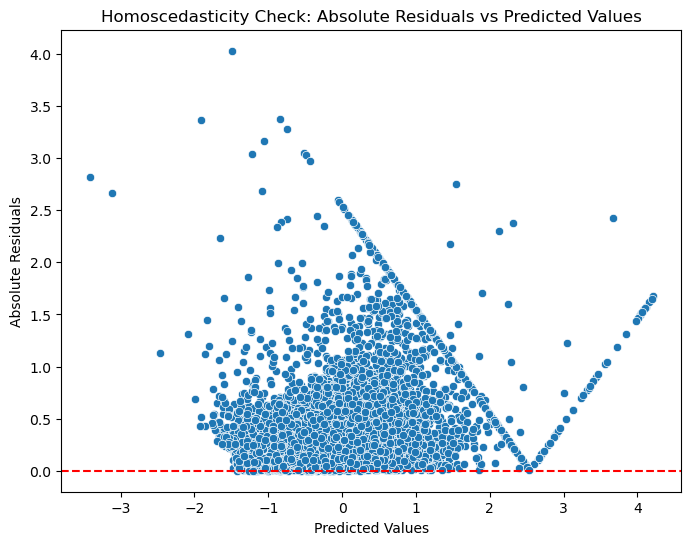

In [113]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_pred, y=np.abs(residuals))
plt.axhline(0, color='red', linestyle='--')
plt.title("Homoscedasticity Check: Absolute Residuals vs Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Absolute Residuals")
plt.show()

In [115]:
# p-value < 0.05, Indicates heteroscedasticity (variance of residuals is not constant).
# The plot shows a funnel shape, where the spread of residuals decreases as predicted values increase.
# This indicates heteroscedasticity, meaning the variance of residuals is not constant.

In [117]:
# 4. Check Normality of Residuals

In [119]:
# The residuals are expected to be normally distributed, should have a bell shaped curve
# This normality assumption is needed to draw inferences and ensures the validity of hypothesis testing, p-values, and CIs

/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


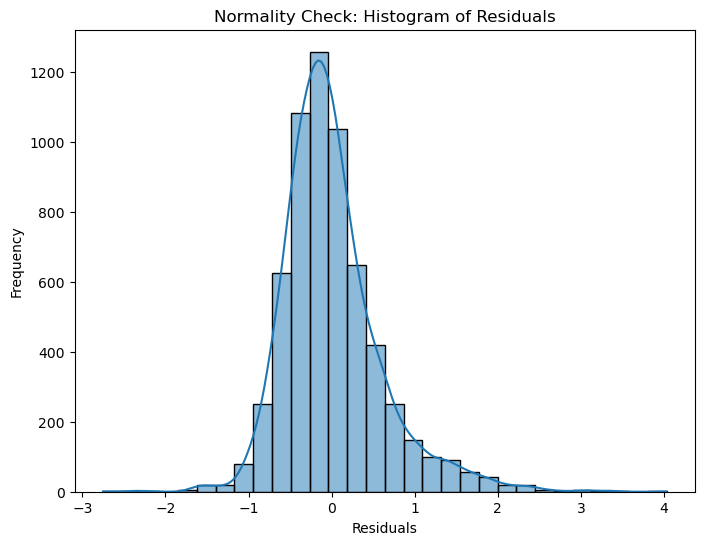

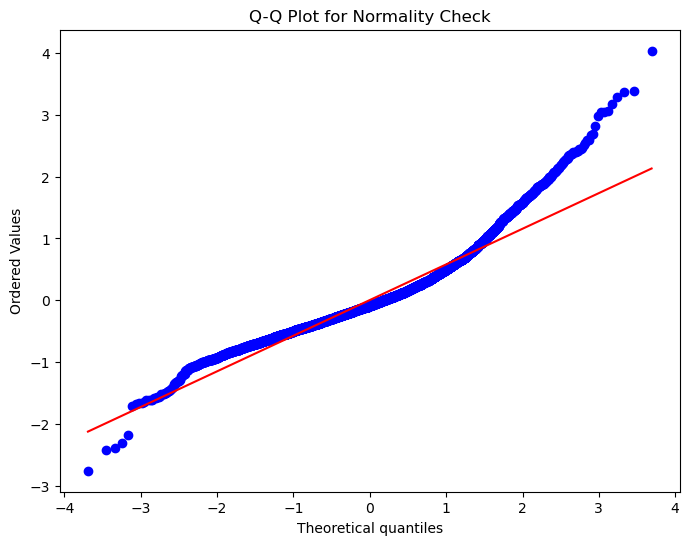

In [136]:
# Histogram
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Normality Check: Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# Q-Q Plot
plt.figure(figsize=(8, 6))
probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot for Normality Check")
plt.show()

In [123]:
# Histogram of residuals is  bell-shaped.
# Q-Q Plot show points lying close to the diagonal line. Hence Normality condition is satisfied

In [125]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-1.327835,1.052548,0.982143,-0.804819,-0.972476,-0.974429,-0.977033,2.344766,0.0,0.0,1.0,0.0
1,-1.322844,1.043185,-0.607019,2.045890,1.357143,0.861439,1.669961,2.332238,0.0,0.0,1.0,0.0
2,-1.332827,1.038503,1.856182,-0.535746,-0.827024,-0.820777,-0.843637,1.782699,0.0,0.0,1.0,0.0
3,-1.337818,1.038503,1.856182,-0.624215,-0.719723,-0.766028,-0.733781,0.932968,0.0,0.0,1.0,0.0
4,-1.337818,1.038503,1.856182,-0.462404,-0.612423,-0.759847,-0.629157,-0.012881,0.0,0.0,1.0,0.0


## Improving the Model

In [128]:
# Based on your findings, suggest and apply methods to improve the model, 
# such as feature engineering, interaction terms, or polynomial regression.

# We create ratio of latitude and longtitude as one of the new feature
# Interact median income with housing median age
# Create polynomial function of median income and median age

In [138]:
# Feature Engineering
X_new = X.copy()  
X_new['longitude_latitude_ratio'] = X_new['longitude'] / X_new['latitude']
X_new['income_age_interaction'] = X_new['median_income'] * X_new['housing_median_age']

# Polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_new[['housing_median_age', 'median_income']])
poly_df = pd.DataFrame(X_poly, columns=poly.get_feature_names_out(['housing_median_age', 'median_income']))

X_new = pd.concat([X_new, poly_df], axis=1)

Y_new = y 

X_new.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,longitude_latitude_ratio,income_age_interaction,1,housing_median_age,median_income,housing_median_age^2,housing_median_age median_income,median_income^2
0,-1.327835,1.052548,0.982143,-0.804819,-0.972476,-0.974429,-0.977033,2.344766,0.0,0.0,1.0,0.0,-1.261543,2.302894,1.0,0.982143,2.344766,0.964604,2.302894,5.497926
1,-1.322844,1.043185,-0.607019,2.045890,1.357143,0.861439,1.669961,2.332238,0.0,0.0,1.0,0.0,-1.268082,-1.415713,1.0,-0.607019,2.332238,0.368472,-1.415713,5.439334
2,-1.332827,1.038503,1.856182,-0.535746,-0.827024,-0.820777,-0.843637,1.782699,0.0,0.0,1.0,0.0,-1.283412,3.309014,1.0,1.856182,1.782699,3.445410,3.309014,3.178017
3,-1.337818,1.038503,1.856182,-0.624215,-0.719723,-0.766028,-0.733781,0.932968,0.0,0.0,1.0,0.0,-1.288218,1.731757,1.0,1.856182,0.932968,3.445410,1.731757,0.870428
4,-1.337818,1.038503,1.856182,-0.462404,-0.612423,-0.759847,-0.629157,-0.012881,0.0,0.0,1.0,0.0,-1.288218,-0.023909,1.0,1.856182,-0.012881,3.445410,-0.023909,0.000166


In [140]:
X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y_new, test_size=0.3, random_state=42)

model = LinearRegression()
model.fit(X_train, Y_train)

Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

In [142]:
train_mse = mean_squared_error(Y_train, Y_train_pred)
test_mse = mean_squared_error(Y_test, Y_test_pred)
train_r2 = r2_score(Y_train, Y_train_pred)
test_r2 = r2_score(Y_test, Y_test_pred)

print("Training Set MSE: ", round(train_mse, 5), "R_square: ", round(train_r2, 5))
print("Testing Set MSE: ", round(test_mse, 5), "R_square: ", round(test_r2, 5))

Training Set MSE:  0.35048 R_square:  0.65165
Testing Set MSE:  0.35239 R_square:  0.64251


In [144]:
X_with_constant = sm.add_constant(X_new)
model = sm.OLS(Y_new, X_with_constant)
results_ols_new = model.fit()

print(results_ols_new.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     2390.
Date:                Sat, 18 Jan 2025   Prob (F-statistic):               0.00
Time:                        01:41:15   Log-Likelihood:                -18462.
No. Observations:               20640   AIC:                         3.696e+04
Df Residuals:                   20623   BIC:                         3.709e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
longitud

In [146]:
# Re-evaluate the improved model and compare its performance with the initial model.

In [148]:
# The new model has slightly higher R_square(0.650) compared to old model(0.645) 
# The new model includes more independent variables (16 compared to 12) 
# However, both models have strong statistical significance with low p-values 

## Conclusion

In [151]:
# Summary of Findings:

# Model Performance:
# The new model has polynomial and interaction features in it, The R square has improved compared to old model.
# The predictors are statistically significant
# The key predictors (median_income, housing_median_age, population, and total_rooms) remained consistent

# Key Predictors:
# Variable - median_income has the most impactful effect on housing prices in both models, 
# Median income in positively correlated with housing prices, which makes sense as higher the income, we can afford high priced houses
# housing_median_age also shows a positive correlation with housing prices,
# Both models indicated potential multicollinearity, particularly with the inclusion of variables like housing_median_age and median_income, as well as the interaction and polynomial terms. This might affect the stability of the coefficient estimates, especially in the improved model.

# Practical Implications:
# Income and Location: Median income remains the most important factor in determining housing prices, 
# Age of the Property: The positive relationship between house age and price tells that older the homes, higher the price
# This can be due factors like historic significance 

# #6 Gradient Descent

In [154]:
# Consider the function:
# f (x, y) = x^2y^2 + x^2 + 2x + 2 + y^2 + 2y

In [156]:
def function(x, y):
    return x**2 * y**2 + x**2 + 2*x + 2 + y**2 + 2*y

In [158]:
# Compute the gradient of the function, denoted as ∇f (x, y)

# Calculating the Gradients - done manually
def gradient(x, y):
    df_dx = 2*x*y**2 + 2*x + 2 #Manually calculated the derivate of function wrt to the x
    df_dy = 2*x**2*y + 2*y + 2 #Manually calculated the derivate of function wrt to the y
    return np.array([df_dx, df_dy])

In [160]:
# Implement the gradient descent algorithm to find the local minima of this function

def gradient_descent(learning_rate, iterations, initial_point):
    x, y = initial_point
    points = [(x, y)]
    values = [function(x, y)]

    for _ in range(iterations):
        grad = gradient(x, y)
        x = x - learning_rate * grad[0]
        y = y - learning_rate * grad[1]
        points.append((x, y))
        values.append(function(x, y))
        #storing the values for plotting the graph

    return np.array(points), np.array(values)

In [162]:
# Learning rate - defines how fast we want to converge to find minima for our function. 
# If it is too high we might overshoot and never find the minima

# Iterations - How many steps we want to take to find the minima. If too less we might never find it

# Initial point - Best to give a initial point near the minima if we understand the function 
# as this will determine the distance to the minima

In [164]:
# Use an appropriate learning rate and number of iterations to ensure convergence.

learning_rate = 0.01
iterations = 1000
initial_point = (1, 1)

# Using initial point of 0,0 as any big positive or big negetive value the function will be very high
# (as squares are present)


In [166]:
# Run gradient descent
points, values = gradient_descent(learning_rate, iterations, initial_point)

In [168]:
df = pd.DataFrame({
    'x': points[:, 0],
    'y': points[:, 1],
    'f(x, y)': values
})

df

,x,y,"f(x, y)"
0,1.000000,1.000000,9.000000
1,0.940000,0.940000,8.307949
2,0.884588,0.884588,7.715647
3,0.833053,0.833053,7.201769
4,0.784829,0.784829,6.750635
...,...,...,...
996,-0.682328,-0.682328,0.418588
997,-0.682328,-0.682328,0.418588
998,-0.682328,-0.682328,0.418588
999,-0.682328,-0.682328,0.418588


In [170]:
# The Above data frame clearly shows that we have reached convergence even before we got to 1000th iteration.
# There is no difference in 999th and 1000th iteration (So for 998, 997 and 996)
# But initially, the changes in function f(x,y) and changes in values of x and y show significant difference for 1st and 2nd iteration

In [172]:
# points

In [174]:
# values

In [176]:
print("The x and y at minima is",points[-1])
print("The f(x,y) at minima is",values[-1])
print("\n")

The x and y at minima is [-0.6823278 -0.6823278]
The f(x,y) at minima is 0.41858782039271003




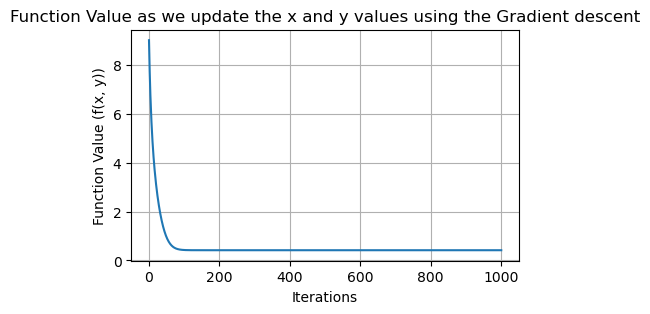

In [178]:
# Plot the function values over iterations to check how gradient descent is working

plt.figure(figsize=(5, 3))
plt.plot(values)
plt.title("Function Value as we update the x and y values using the Gradient descent")
plt.grid()
plt.xlabel("Iterations")
plt.ylabel("Function Value (f(x, y))")
plt.show()


In [180]:
# Discuss the choice of learning rate and any challenges faced during implementation

In [182]:
# A learning rate of 0.01 is used as it is optimal between convergence speed and stability. 
# (took 60 iterations to reach minima)
# Higher learning rates (e.g., 1) caused overshooting near the minima, 
# while lower rates (e.g., 0.001) made convergence very slow (took about 700 iterations to reach minima)
# We also tried with learning rate of 0.1, it did not cause any issue (took 5 iterations to reach minima)

# Challenges faced:
# The function is non-linear and multi-dimensional, so it can go very high with slight increase in values.
# Selecting an initial point near the minima helps accelerate convergence. Tested with a high value 100,100. 
# The convergence was super slow